In [147]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionResNetV2
from glob import glob
import xml.etree.ElementTree as xet
import json
import plotly.express as px

In [2]:
json_path = ("C:/Users/a1003/practice/object_detection/labeling")
image_path = ("C:/Users/a1003/practice/object_detection/data")
inputs_data = []
target_data = []
for file in os.listdir(json_path):
    path = str(json_path + '/' + str(file))
    with open(path, 'r') as f:
        data = json.load(f)
        label = data['shapes'][0]["label"]
        imagepath = data["imagePath"]
        imp = image_path + "/" + imagepath
        image_data = cv2.imread(imp)
        origin_w = image_data.shape[1]
        origin_h = image_data.shape[0]
        resized_image = cv2.resize(image_data, (244, 244))
        normalized_image = resized_image/255

        x_point_1 = data['shapes'][0]["points"][0][0]
        x_point_2 = data['shapes'][0]["points"][1][0]
        x_point_3 = data['shapes'][0]["points"][2][0]
        x_point_4 = data['shapes'][0]["points"][3][0]
        
        y_point_1 = data['shapes'][0]["points"][0][1]
        y_point_2 = data['shapes'][0]["points"][1][1]
        y_point_3 = data['shapes'][0]["points"][2][1]
        y_point_4 = data['shapes'][0]["points"][3][1]
        
        new_x_point_1 = x_point_1/origin_w
        new_x_point_2 = x_point_2/origin_w
        new_x_point_3 = x_point_3/origin_w
        new_x_point_4 = x_point_4/origin_w
        
        new_y_point_1 = y_point_1/origin_h
        new_y_point_2 = y_point_2/origin_h
        new_y_point_3 = y_point_3/origin_h
        new_y_point_4 = y_point_4/origin_h
        
        x_cen = (new_x_point_1 + new_x_point_2 + new_x_point_3 + new_x_point_4)/4 
        y_cen = (new_y_point_1 + new_y_point_2 + new_y_point_3 + new_y_point_4)/4 
        
        outputs = [x_cen, y_cen]
        
        inputs_data.append(normalized_image)
        target_data.append(outputs)

        
        
        
#with open(json_path, 'r') as f:
#  data = json.load(f)

In [3]:
inputs_data = np.array(inputs_data)
target_data = np.array(target_data)

In [4]:
inputs_data.shape

(159, 244, 244, 3)

In [5]:
target_data.shape

(159, 2)

In [6]:
def retangle_image_plot(image, targets):
    plt.imshow(image)
    plt.plot([targets[0], targets[1]], [targets[4], targets[5]])
    plt.plot([targets[1], targets[2]], [targets[5], targets[6]])
    plt.plot([targets[2], targets[3]], [targets[6], targets[7]])
    plt.plot([targets[0], targets[3]], [targets[4], targets[7]])


In [7]:
def center_image_plot(image, targets):
    plt.imshow(image)
    plt.scatter(targets[0], targets[1], c = 'red')


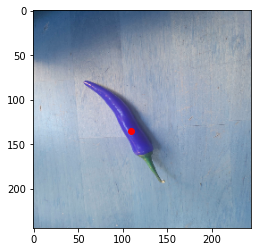

In [8]:
center_image_plot(image = inputs_data[30], targets = target_data[30]*244)

In [9]:
from sklearn.model_selection import train_test_split

In [18]:
x_train, x_test, y_train, y_test = train_test_split(inputs_data, target_data, test_size = 0.3, random_state = 42)

In [19]:
x_train.shape

(111, 244, 244, 3)

In [20]:
x_test.shape

(48, 244, 244, 3)

In [21]:
y_train.shape

(111, 2)

In [22]:
y_test.shape

(48, 2)

In [23]:
import tensorflow as tf

In [24]:
input_shape = x_train[0].shape
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', input_shape = input_shape))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dense(2, activation = 'sigmoid'))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 242, 242, 128)     3584      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 240, 240, 128)     147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 120, 120, 128)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 118, 118, 64)      73792     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 116, 116, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 58, 58, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 32)       

In [26]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="callbacks", 
    verbose=1, 
    save_weights_only=True)

model.compile(
                optimizer = 'adam',
                loss= tf.keras.losses.binary_crossentropy
                )
history = model.fit(x_train, y_train, epochs = 100, validation_data = (x_test, y_test), callbacks=[cp_callback])

Train on 111 samples, validate on 48 samples
Epoch 1/100
 96/111 [========================>.....] - ETA: 6s - loss: 0.6959 
Epoch 00001: saving model to callbacks
111/111 [==============================] - 51s 456ms/sample - loss: 0.6956 - val_loss: 0.6932
Epoch 2/100
 96/111 [========================>.....] - ETA: 6s - loss: 0.6930 
Epoch 00002: saving model to callbacks
111/111 [==============================] - 52s 471ms/sample - loss: 0.6930 - val_loss: 0.6939
Epoch 3/100
 96/111 [========================>.....] - ETA: 6s - loss: 0.6935 
Epoch 00003: saving model to callbacks
111/111 [==============================] - 52s 469ms/sample - loss: 0.6935 - val_loss: 0.6930
Epoch 4/100
 96/111 [========================>.....] - ETA: 6s - loss: 0.6932 
Epoch 00004: saving model to callbacks
111/111 [==============================] - 53s 480ms/sample - loss: 0.6932 - val_loss: 0.6929
Epoch 5/100
 96/111 [========================>.....] - ETA: 6s - loss: 0.6932 
Epoch 00005: saving model to

 96/111 [========================>.....] - ETA: 6s - loss: 0.6909 
Epoch 00039: saving model to callbacks
111/111 [==============================] - 58s 519ms/sample - loss: 0.6908 - val_loss: 0.6914
Epoch 40/100
 96/111 [========================>.....] - ETA: 7s - loss: 0.6908 
Epoch 00040: saving model to callbacks
111/111 [==============================] - 58s 524ms/sample - loss: 0.6907 - val_loss: 0.6913
Epoch 41/100
 96/111 [========================>.....] - ETA: 7s - loss: 0.6911 
Epoch 00041: saving model to callbacks
111/111 [==============================] - 58s 525ms/sample - loss: 0.6909 - val_loss: 0.6919
Epoch 42/100
 96/111 [========================>.....] - ETA: 6s - loss: 0.6906 
Epoch 00042: saving model to callbacks
111/111 [==============================] - 58s 519ms/sample - loss: 0.6905 - val_loss: 0.6913
Epoch 43/100
 96/111 [========================>.....] - ETA: 6s - loss: 0.6902 
Epoch 00043: saving model to callbacks
111/111 [==============================] -

Epoch 78/100
 96/111 [========================>.....] - ETA: 7s - loss: 0.6884 
Epoch 00078: saving model to callbacks
111/111 [==============================] - 61s 554ms/sample - loss: 0.6884 - val_loss: 0.6925
Epoch 79/100
 96/111 [========================>.....] - ETA: 7s - loss: 0.6884 
Epoch 00079: saving model to callbacks
111/111 [==============================] - 66s 598ms/sample - loss: 0.6884 - val_loss: 0.6924
Epoch 80/100
 96/111 [========================>.....] - ETA: 7s - loss: 0.6882 
Epoch 00080: saving model to callbacks
111/111 [==============================] - 64s 580ms/sample - loss: 0.6884 - val_loss: 0.6924
Epoch 81/100
 96/111 [========================>.....] - ETA: 7s - loss: 0.6886 
Epoch 00081: saving model to callbacks
111/111 [==============================] - 65s 583ms/sample - loss: 0.6884 - val_loss: 0.6925
Epoch 82/100
 96/111 [========================>.....] - ETA: 7s - loss: 0.6881 
Epoch 00082: saving model to callbacks
111/111 [====================

In [27]:
model.save('model_1408')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_1408\assets


In [55]:
input_image = x_train[22]

Image = np.expand_dims(input_image, axis=0)
Image.shape

(1, 244, 244, 3)

In [56]:
prediction = model.predict(Image)
prediction

array([[0.45354456, 0.43536493]], dtype=float32)

In [57]:
y_test[0]

array([0.61467956, 0.56680381])

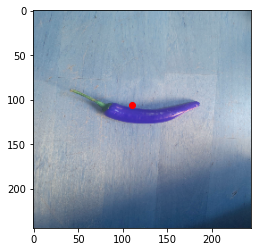

In [58]:
center_image_plot(image = input_image, targets = prediction[0]*244)

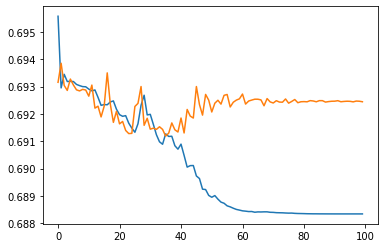

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

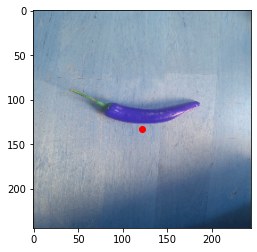

In [60]:

center_image_plot(image = input_image, targets = y_test[22]*244)

In [190]:
def center_prediction_pipeline(im, model):
    im=im
    origin_w = im.shape[1]
    origin_h = im.shape[0]
    resized_image = cv2.resize(im, (244, 244))
    normalized_image = resized_image/255
    Image = np.expand_dims(normalized_image, axis=0)
    prediction = model.predict(Image)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    image = cv2.circle(im, (int(prediction[0][0]*origin_w),int(prediction[0][1]*origin_h)), radius=25, color=(0, 0, 255), thickness = -1)
    return px.imshow(image)

In [191]:
prediction

array([[0.41837752, 0.5296708 ]], dtype=float32)


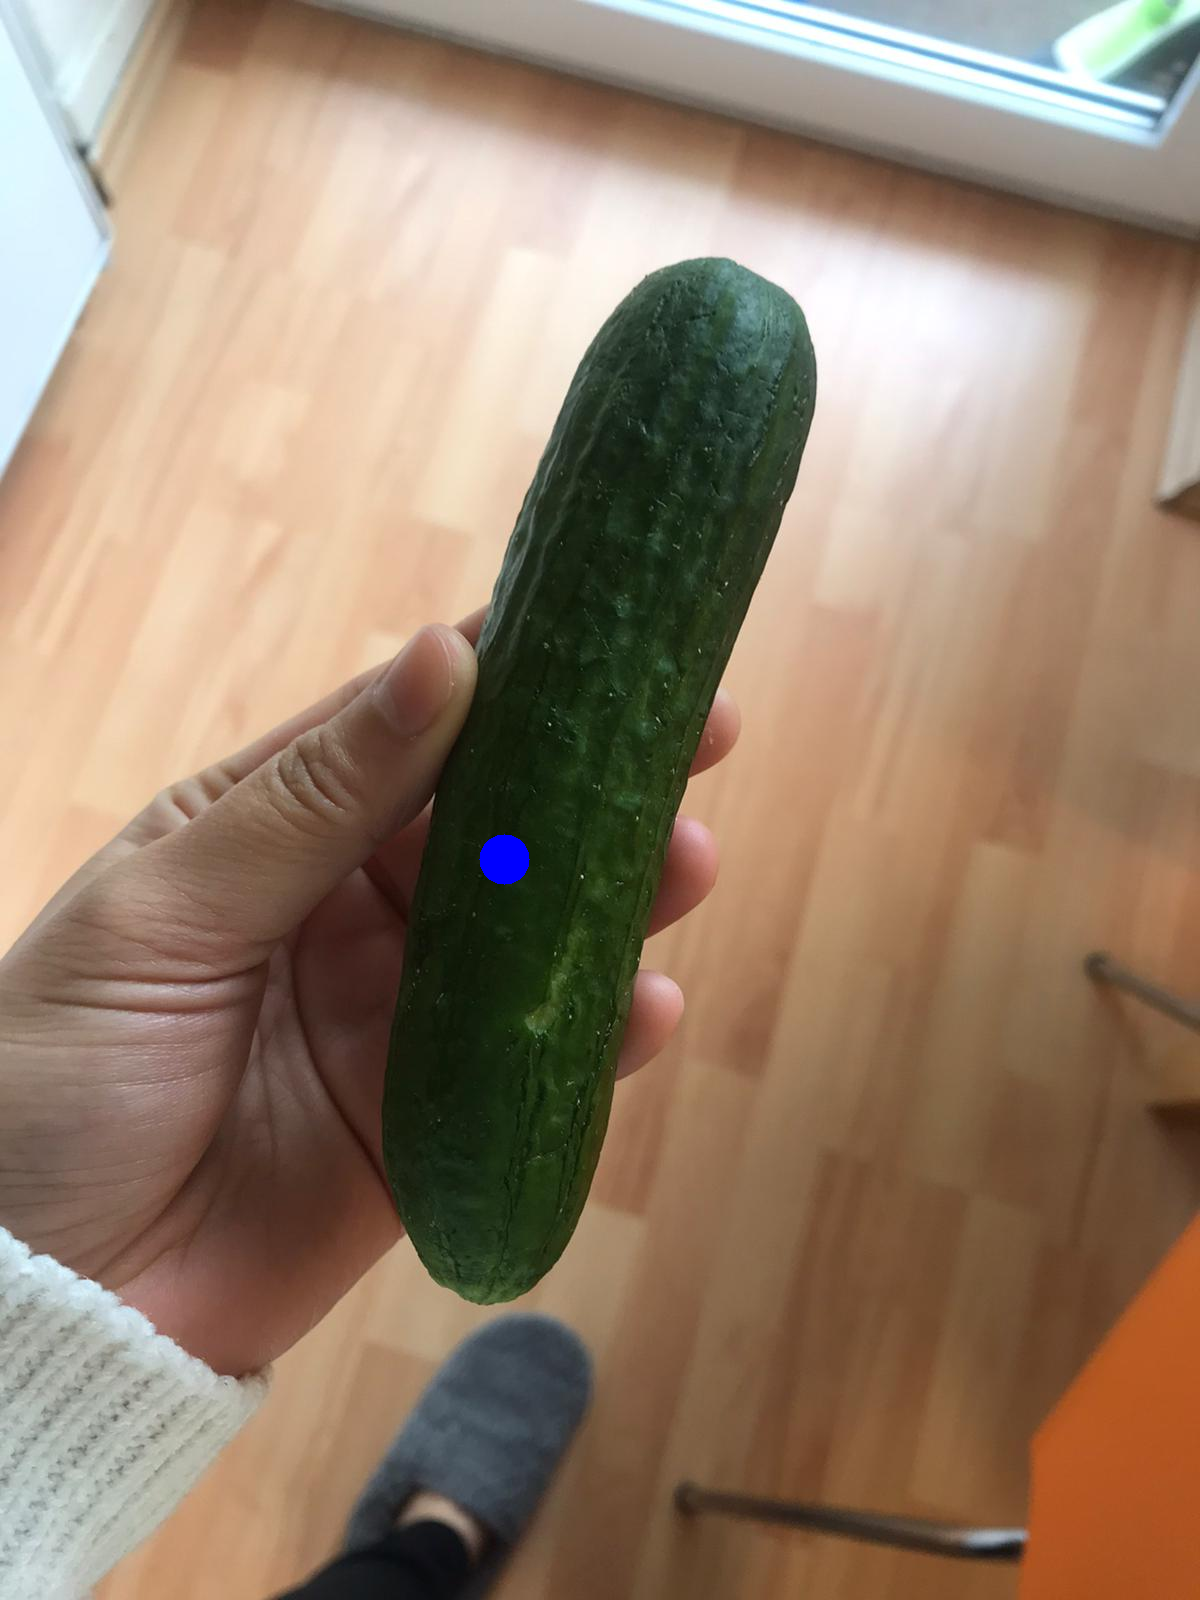

In [192]:
im = cv2.imread("C:/Users/a1003/practice/object_detection/data/C18.jpeg")
center_prediction_pipeline(im, model)

In [181]:
im = cv2.imread("C:/Users/a1003/practice/object_detection/data/C18.jpeg", cv2.IMREAD_COLOR)
RGB_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
image = cv2.circle(RGB_img, (500,800), radius=25, color=(0, 0, 255), thickness = -1)


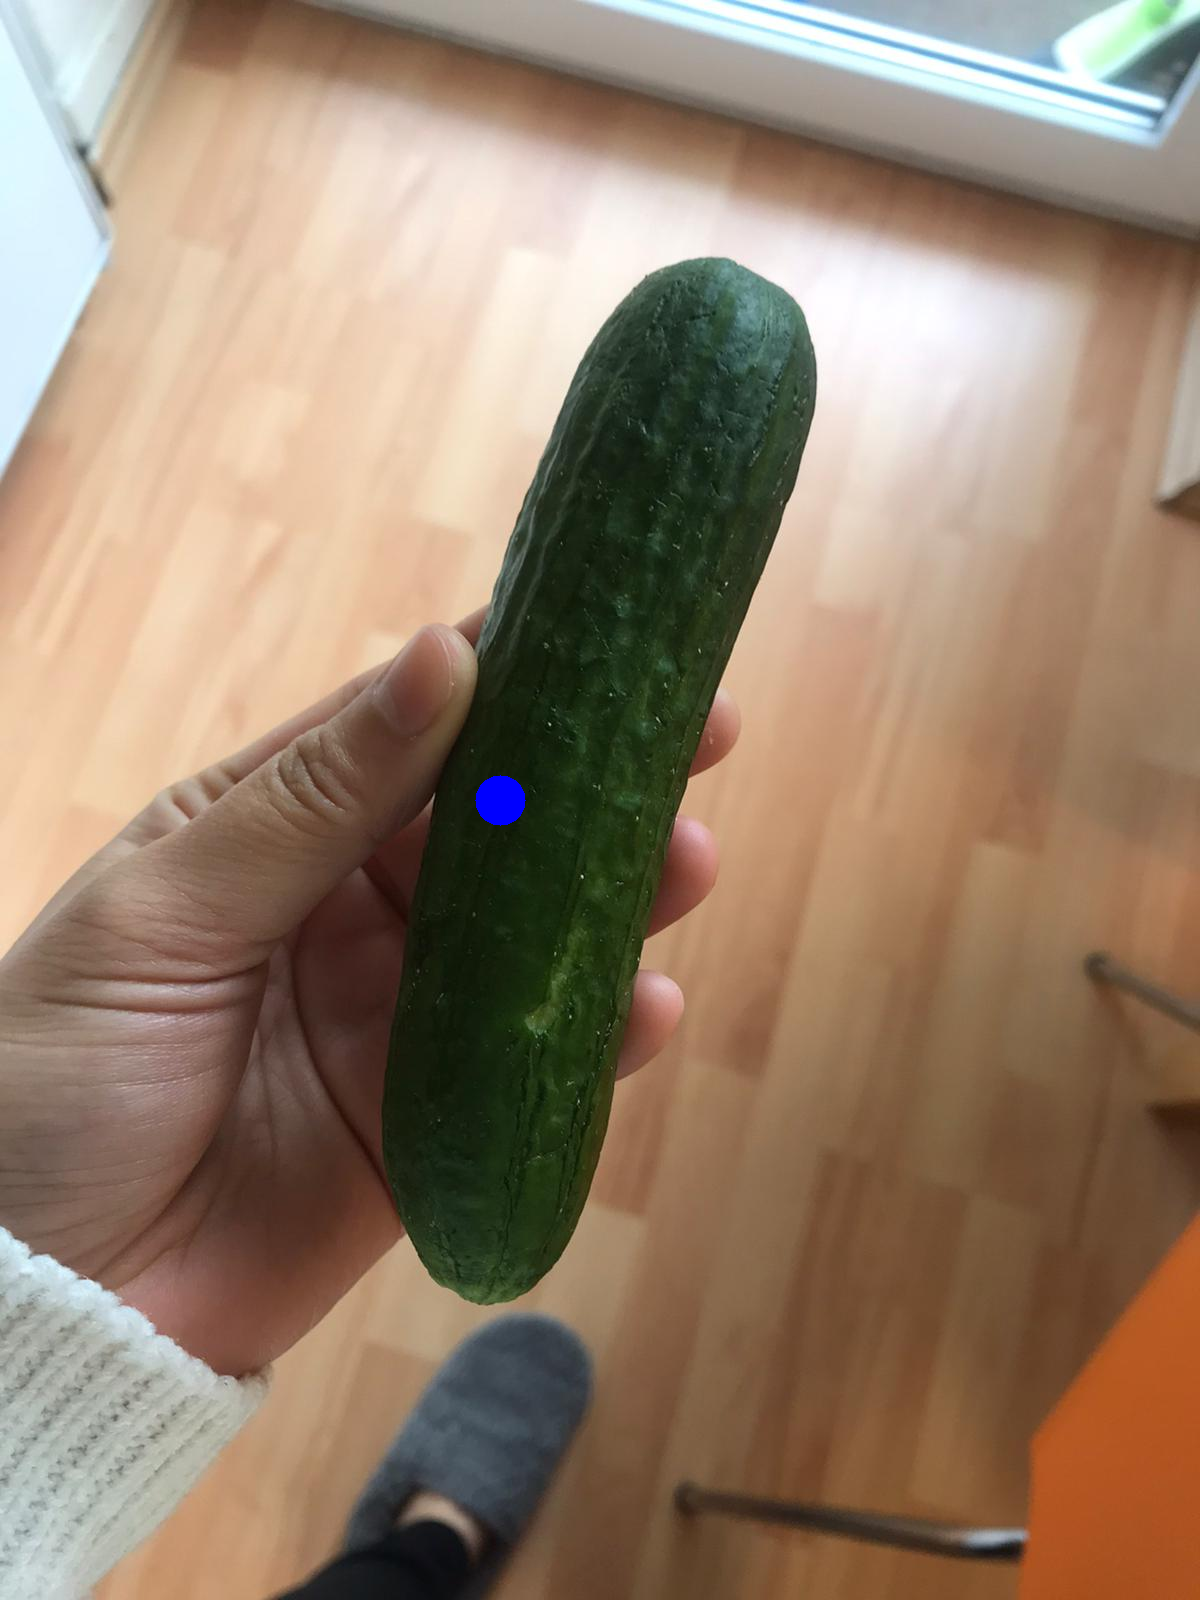

In [182]:
px.imshow(image)